In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras import layers
from tensorflow.keras import optimizers, losses, metrics, Model

In [ ]:
!pip install tensorflow-addons==0.16.1
import tensorflow_addons as tfa

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 47.5 MB/s eta 0:00:00


/usr/local/lib/python3.9/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.6.0 and strictly below 2.9.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.11.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


In [ ]:
!pip install tensorflow_wavelets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from tensorflow_addons.losses import ContrastiveLoss

In [ ]:
import tensorflow_wavelets.Layers.DWT as DWT

In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms

In [ ]:
from mpl_toolkits import mplot3d

In [ ]:
import cv2
from google.colab.patches import cv2_imshow

In [ ]:
import pywt

**Steps:**
*   We create two different versions of the same dataset with a stochastic data augmentation pipeline. Note that the random initialization seed needs to be the same during create these versions.
*   We take a ResNet without any classification head (backbone) and we add a shallow fully-connected network (projection head) on top of it. Collectively, this is known as the encoder.
*   We pass the output of the encoder through a predictor which is again a shallow fully-connected network having an AutoEncoder like structure.
* We then train our encoder to maximize the cosine similarity between the two different versions of our dataset.

In [ ]:
AUTO = tf.data.AUTOTUNE
BATCH_SIZE = 64
EPOCHS = 3
CROP_TO = 32
HEIGHT = 32
WIDTH = 32
SEED = 26
PROJECT_DIM = 2048
LATENT_DIM = 512
WEIGHT_DECAY = 0.0005

In [ ]:
CROP_TO_DWT = 64
dim_DWT = 1
WIDTH_DWT = 64
HEIGHT_DWT = 64
dwt_modes = 4

Let's Understand why our PROJECT_DIM = 2048 and LATENT_DIM = 512


In [ ]:
resnet_model = tf.keras.applications.ResNet50(input_shape=(WIDTH, HEIGHT, 3),weights=None, include_top=False, pooling='avg')
resnet_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 38, 38, 3)    0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 16, 16, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 16, 16, 64)   256         ['conv1_conv[0][0]']             
                                                                                           

We can see that PROJECT_DIM is the output shape of our resnet50 model
and LATENT_DIM is the output shape of the Last Convolutional_ReLU layer of our resnet50 model

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

170498071/170498071 [==============================] - 2s 0us/step


Let's Understand why Height = 3 and Width = 3

In [ ]:
x_train.shape

(50000, 32, 32, 3)

In [ ]:
x_test.shape

(10000, 32, 32, 3)

We can see that the dimension of all the images in both test and train data is 32,32,3 which expains why Height = 3 and Width = 3.There are three colour channels (ie.RGB) and that's why the last dimension = 3.

Let's Now visualise one image 

In [ ]:
x_train[0].shape

(32, 32, 3)

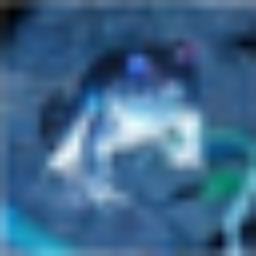

In [ ]:
sample = x_train[0]
sample = cv2.resize(sample,(256,256))
cv2_imshow(sample)

In [ ]:
sample.shape

(256, 256, 3)

Having the right data augmentation pipeline is critical for SSL systems to work effectively in computer vision. Two particular augmentation transforms that are most effective are: 
                             1. Random resized crops and 
                             2. Color distortions. 

It should be noted that an augmentation pipeline is generally dependent on various properties of the dataset we are dealing with. For example, if images in the dataset are heavily object-centric then taking random crops with a very high probability may hurt the training performance.

In [ ]:
def flip_random_crop(image):
    # With random crops we also apply horizontal flipping.
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_crop(image, (CROP_TO, CROP_TO, 3))
    return image

def flip_random_crop_dwt(image):
    # With random crops we also apply horizontal flipping.
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_crop(image, (CROP_TO_DWT, CROP_TO_DWT, 3))
    return image

def color_jitter(x, strength=[0.4, 0.4, 0.4, 0.1]):
    x = tf.image.random_brightness(x, max_delta=0.8 * strength[0])
    x = tf.image.random_contrast(
        x, lower=1 - 0.8 * strength[1], upper=1 + 0.8 * strength[1]
    )
    x = tf.image.random_saturation(
        x, lower=1 - 0.8 * strength[2], upper=1 + 0.8 * strength[2]
    )
    x = tf.image.random_hue(x, max_delta=0.2 * strength[3])
    # Affine transformations can disturb the natural range of
    # RGB images, hence this is needed.
    x = tf.clip_by_value(x, 0, 255)
    return x

def color_drop(x):
    x = tf.image.rgb_to_grayscale(x)
    x = tf.tile(x, [1, 1, 3])
    return x

def random_apply(func, x, p):
    if tf.random.uniform([], minval=0, maxval=1) < p:
        return func(x)
    else:
        return x


def convert_to_grayscale(image):
  image = np.array(image) 
  image_grayscale = cv2.cvtColor(D_V1[i], cv2.COLOR_BGR2GRAY)
  return image_grayscale

def custom_augment(image):
    # As discussed in the SimCLR paper, the series of augmentation
    # transformations (except for random crops) need to be applied
    # randomly to impose translational invariance.
    image = flip_random_crop(image)
    image = random_apply(color_jitter, image, p=0.8)
    image = random_apply(color_drop, image, p=0.2)
    return image

def custom_augment_dwt(image):
    # As discussed in the SimCLR paper, the series of augmentation
    # transformations (except for random crops) need to be applied
    # randomly to impose translational invariance.
    image = flip_random_crop_dwt(image)
    image = random_apply(color_jitter, image, p=0.8)
    image = random_apply(color_drop, image, p=0.2)
    return image

In [ ]:
dim_DWT

1

In [ ]:
#Creating a Grayscale Version of the same Dataset-1
BATCH_SIZE_DWT = 1
ssl_ds_one_gs = tf.data.Dataset.from_tensor_slices(x_train)
ssl_ds_one_gs = (ssl_ds_one_gs.shuffle(1024, seed=SEED).map(custom_augment_dwt, num_parallel_calls=AUTO).batch(BATCH_SIZE_DWT).prefetch(AUTO))

#Creating a Grayscale Version of the same Dataset-2
ssl_ds_two_gs = tf.data.Dataset.from_tensor_slices(x_train)
ssl_ds_two_gs = (ssl_ds_two_gs.shuffle(1024, seed=SEED).map(custom_augment_dwt, num_parallel_calls=AUTO).batch(BATCH_SIZE_DWT).prefetch(AUTO))

#We then zip both of these datasets.
ssl_ds_gs = tf.data.Dataset.zip((ssl_ds_one_gs, ssl_ds_two_gs))

In [ ]:
ss = tf.data.Dataset.from_tensor_slices(x_train)
ss

<TensorSliceDataset element_spec=TensorSpec(shape=(32, 32, 3), dtype=tf.uint8, name=None)>

In [ ]:
ss1 = (ss.shuffle(1024, seed=SEED).map(custom_augment_dwt, num_parallel_calls=AUTO).batch(BATCH_SIZE_DWT).prefetch(AUTO))
ss1

<PrefetchDataset element_spec=TensorSpec(shape=(None, 64, 64, 3), dtype=tf.uint8, name=None)>

Now we convert the data into TensorFlow Dataset objects
Here we create two different versions of our dataset without any ground-truth labels.



In [ ]:
x_train_grayscale = [ ]
for i in range(len(x_train)):
  gs_img = cv2.cvtColor(x_train[i], cv2.COLOR_BGR2GRAY)
  gs_img = cv2.resize(gs_img,(64,64))
  gs_img = gs_img.reshape((64,64,1))
  x_train_grayscale.append(gs_img)
x_train_grayscale = np.array(x_train_grayscale)

In [ ]:
x_train_grayscale.shape

(50000, 64, 64, 1)

In [ ]:
x_train_rescale = [ ]
for i in range(len(x_train)):
  #gs_img = cv2.cvtColor(x_train[i], cv2.COLOR_BGR2GRAY)
  gs_img = cv2.resize(x_train[i],(64,64))
  #gs_img = gs_img.reshape((64,64,1))
  x_train_rescale.append(gs_img)
x_train_rescale = np.array(x_train_rescale)

In [ ]:
x_train_rescale.shape

(50000, 64, 64, 3)

In [ ]:
BATCH_SIZE_DWT = 64
ssl_ds_one_rs = tf.data.Dataset.from_tensor_slices(x_train_rescale)
ssl_ds_one_rs = (ssl_ds_one_rs.shuffle(1024, seed=SEED).map(custom_augment_dwt, num_parallel_calls=AUTO).batch(BATCH_SIZE_DWT).prefetch(AUTO))

#Creating a Grayscale Version of the same Dataset-2
ssl_ds_two_rs = tf.data.Dataset.from_tensor_slices(x_train_rescale)
ssl_ds_two_rs = (ssl_ds_two_rs.shuffle(1024, seed=SEED).map(custom_augment_dwt, num_parallel_calls=AUTO).batch(BATCH_SIZE_DWT).prefetch(AUTO))

#We then zip both of these datasets.
ssl_ds_rs = tf.data.Dataset.zip((ssl_ds_one_rs, ssl_ds_two_rs))

In [ ]:
ssl_ds_rs

<ZipDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(None, 64, 64, 3), dtype=tf.uint8, name=None))>

In [ ]:
#Training Dataset version 1
ssl_ds_one = tf.data.Dataset.from_tensor_slices(x_train)
ssl_ds_one = (ssl_ds_one.shuffle(1024, seed=SEED).map(custom_augment, num_parallel_calls=AUTO).batch(BATCH_SIZE).prefetch(AUTO))

#Training Dataset version 2
ssl_ds_two = tf.data.Dataset.from_tensor_slices(x_train)
ssl_ds_two = (ssl_ds_two.shuffle(1024, seed=SEED).map(custom_augment, num_parallel_calls=AUTO).batch(BATCH_SIZE).prefetch(AUTO))

#We then zip both of these datasets.
ssl_ds = tf.data.Dataset.zip((ssl_ds_one, ssl_ds_two))

Visualising Few Images

This is the first set of images:


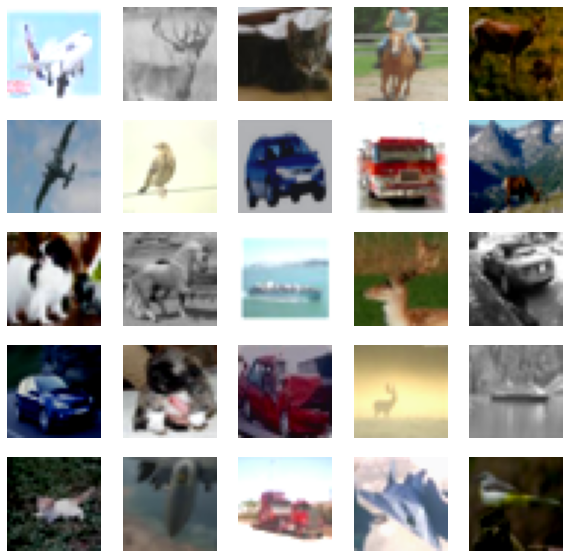

This is the second set of images:


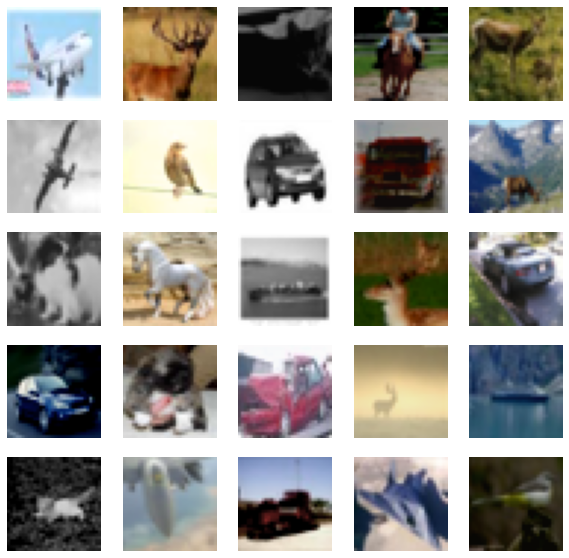

In [ ]:
# Visualize a few augmented images.
print('This is the first set of images:')
sample_images_one = next(iter(ssl_ds_one))
plt.figure(figsize=(10, 10))
for n in range(25):
    ax = plt.subplot(5, 5, n + 1)
    plt.imshow(sample_images_one[n].numpy().astype("int"))
    plt.axis("off")
plt.show()

print('This is the second set of images:')
# Ensure that the different versions of the dataset actually contain
# identical images.
sample_images_two = next(iter(ssl_ds_two))
plt.figure(figsize=(10, 10))
for n in range(25):
    ax = plt.subplot(5, 5, n + 1)
    plt.imshow(sample_images_two[n].numpy().astype("int"))
    plt.axis("off")
plt.show()

We can see that the images in the first sample and the second sample are the same but are augmented differently.

Now we define the Loss function

In [ ]:
def cosine_similarity(p, z):
    # The authors of SimSiam emphasize the impact of
    # the `stop_gradient` operator in the paper as it
    # has an important role in the overall optimization.
    z = tf.stop_gradient(z)
    p = tf.math.l2_normalize(p, axis=1)
    z = tf.math.l2_normalize(z, axis=1)
    # Negative cosine similarity (minimizing this is
    # equivalent to maximizing the similarity).
    return -tf.reduce_mean(tf.reduce_sum((p * z), axis=1))

In [ ]:
#Alternatively we can use the inbuilt Cosine Similarity loss function in Tensorflow as well.
#loss = tf.keras.losses.CosineSimilarity(axis=1)

**Defining the encoder and the predictor:**
We use an implementation of ResNet50 pretrained model.

In [ ]:
from tensorflow.keras.applications import resnet50

We define the encoder and predictor now.

In [ ]:
N = 2
DEPTH = N * 9 + 2
NUM_BLOCKS = ((DEPTH - 2) // 9) - 1

In [ ]:
def encoder():
    model = tf.keras.Sequential(
           [ 
             # Input and backbone.
             tf.keras.layers.Input((CROP_TO, CROP_TO, 3)),
             DWT.DWT(name="haar",concat=0),
             tf.keras.layers.InputLayer(input_shape = (WIDTH,HEIGHT,3)),
             tf.keras.applications.ResNet50(input_shape=(WIDTH, HEIGHT, 3),weights=None, include_top=False, pooling='avg'), 
             tf.keras.layers.Dense(PROJECT_DIM),

             # Projection head.
             tf.keras.layers.Dense(PROJECT_DIM,use_bias=False,kernel_regularizer=regularizers.l2(WEIGHT_DECAY)),
             tf.keras.layers.BatchNormalization(),
             tf.keras.layers.ReLU(),
             tf.keras.layers.Dense(PROJECT_DIM,use_bias=False,kernel_regularizer=regularizers.l2(WEIGHT_DECAY)),
             tf.keras.layers.BatchNormalization()
           ] ,
           name = "Encoder"
    )
    return model


def predictor():
    model = tf.keras.Sequential(
        [
            # Note the AutoEncoder-like structure.
            tf.keras.layers.Input((PROJECT_DIM,)),
            tf.keras.layers.Dense(LATENT_DIM,use_bias=False,kernel_regularizer=regularizers.l2(WEIGHT_DECAY),),
            tf.keras.layers.ReLU(),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dense(PROJECT_DIM),
        ],
        name="predictor",
    )
    return model

In [ ]:
input_shape = (None, 32, 32, 4)
input_shape_gs = (None,32,32,1)
def encoder_dwt():
    model = tf.keras.Sequential(
           [ 
             # Input and backbone.
             tf.keras.layers.Input((CROP_TO_DWT, CROP_TO_DWT, 3)),
             tf.keras.layers.InputLayer(input_shape = (WIDTH_DWT,HEIGHT_DWT,3)),
             tf.keras.layers.Conv2D(1, 3,activation='relu',padding="same",input_shape=input_shape_gs[1:]),
             DWT.DWT(name="haar",concat=0),
             #tf.keras.layers.Conv2D(4, 1024),
             tf.keras.layers.Conv2D(3, 4,activation='relu',padding="same",input_shape=input_shape[1:]),
             tf.keras.applications.ResNet50(input_shape=(WIDTH, HEIGHT , 3),weights=None, include_top=False, pooling='avg'), 
             tf.keras.layers.Dense(PROJECT_DIM),

             # Projection head.
             tf.keras.layers.Dense(PROJECT_DIM,use_bias=False,kernel_regularizer=regularizers.l2(WEIGHT_DECAY)),
             tf.keras.layers.BatchNormalization(),
             tf.keras.layers.ReLU(),
             tf.keras.layers.Dense(PROJECT_DIM,use_bias=False,kernel_regularizer=regularizers.l2(WEIGHT_DECAY)),
             tf.keras.layers.BatchNormalization()
           ] ,
           name = "Encoder"
    )
    return model


def predictor_dwt():
    model = tf.keras.Sequential(
        [
            # Note the AutoEncoder-like structure.
            tf.keras.layers.Input((PROJECT_DIM,)),
            tf.keras.layers.Dense(LATENT_DIM,use_bias=False,kernel_regularizer=regularizers.l2(WEIGHT_DECAY),),
            tf.keras.layers.ReLU(),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dense(PROJECT_DIM),
        ],
        name="predictor",
    )
    return model

Alternative Way to Define the Model as a Sequence Instead of Breaking into Encoder and Decoder 
(For my reference and done as an excercise for better understanding of the model)

In [ ]:
#Alternate way to Build the Model (ie building the encoder and decoder together in the same model)
#Implemented here just for Self-learning(Understanding the Architecture Better)
def SSL_Model():
  #Building the Basic Model Architecture
  model = tf.keras.Sequential(
             [   #Building the Resnet Model Backbone attached to the Projection Head 
                 tf.keras.applications.ResNet50(input_shape=(WIDTH, HEIGHT, 3),weights=None, include_top=False, pooling='avg'),
                 #tf.keras.applications.ResNet50(weights=None, include_top=False),#, pooling='avg'),
                 #Building the Projection Head which is a fully connected layer which produces the resnet layer's output 
                 tf.keras.layers.Dense(PROJECT_DIM),
                 #tf.keras.layers.Flatten()
             ]
                             )
  #Finally Building the Predictor 
  model.add(tf.keras.Sequential(
        [
            # Note the AutoEncoder-like structure.
            layers.Input((PROJECT_DIM, )),
            layers.Dense(LATENT_DIM,use_bias=False,kernel_regularizer=regularizers.l2(WEIGHT_DECAY),),
            layers.ReLU(),
            layers.BatchNormalization(),
            layers.Dense(PROJECT_DIM),
            layers.Flatten()
        ],name="predictor",
    ))
  return model

To Visualise the Model better Lets Build the whole model including Resnet Backbone,Projection Head as well as the Predictor in the same sequential layer.

In [ ]:
visualization_sample_model = tf.keras.Sequential(
             [    # Input and backbone.
                  tf.keras.layers.Input((CROP_TO, CROP_TO, 3)),
                  tf.keras.layers.InputLayer(input_shape = (WIDTH,HEIGHT,3)),
                  tf.keras.applications.ResNet50(input_shape=(WIDTH, HEIGHT, 3),weights=None, include_top=False, pooling='avg'), 
                  tf.keras.layers.Dense(PROJECT_DIM),

                  # Projection head.
                  tf.keras.layers.Dense(PROJECT_DIM,use_bias=False,kernel_regularizer=regularizers.l2(WEIGHT_DECAY)),
                  tf.keras.layers.BatchNormalization(),
                  tf.keras.layers.ReLU(),
                  tf.keras.layers.Dense(PROJECT_DIM,use_bias=False,kernel_regularizer=regularizers.l2(WEIGHT_DECAY)),
                  tf.keras.layers.BatchNormalization(),

                  #Predictor
                  # Note the AutoEncoder-like structure.
                  tf.keras.layers.Input((PROJECT_DIM,)),
                  tf.keras.layers.Dense(LATENT_DIM,use_bias=False,kernel_regularizer=regularizers.l2(WEIGHT_DECAY),),
                  tf.keras.layers.ReLU(),
                  tf.keras.layers.BatchNormalization(),
                  tf.keras.layers.Dense(PROJECT_DIM),

             ]
                             )
visualization_sample_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        multiple                  0         
                                                                 
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense_5 (Dense)             (None, 2048)              4196352   
                                                                 
 dense_6 (Dense)             (None, 2048)              4194304   
                                                                 
 batch_normalization_3 (Batc  (None, 2048)             8192      
 hNormalization)                                                 
                                                                 
 re_lu_2 (ReLU)              (None, 2048)              0         
                                                      

In [ ]:
dummy_model = tf.keras.Sequential(
           [ 
             # Input and backbone.
             tf.keras.layers.Input((CROP_TO_DWT, CROP_TO_DWT, dim_DWT)),
             tf.keras.layers.InputLayer(input_shape = (WIDTH_DWT,HEIGHT_DWT,dim_DWT)),
             DWT.DWT(name="haar",concat=0),
             tf.keras.layers.Conv2D(3, 4,activation='relu',padding="same",input_shape=input_shape[1:]),
             tf.keras.applications.ResNet50(input_shape=(WIDTH, HEIGHT , 3 ),weights=None, include_top=False, pooling='avg'), 
             tf.keras.layers.Dense(PROJECT_DIM),
             # Projection head.
             tf.keras.layers.Dense(PROJECT_DIM,use_bias=False,kernel_regularizer=regularizers.l2(WEIGHT_DECAY)),
             tf.keras.layers.BatchNormalization(),
             tf.keras.layers.ReLU(),
             tf.keras.layers.Dense(PROJECT_DIM,use_bias=False,kernel_regularizer=regularizers.l2(WEIGHT_DECAY)),
             tf.keras.layers.BatchNormalization(),
             #Predictor
             tf.keras.layers.Input((PROJECT_DIM,)),
             tf.keras.layers.Dense(LATENT_DIM,use_bias=False,kernel_regularizer=regularizers.l2(WEIGHT_DECAY),),
             tf.keras.layers.ReLU(),
             tf.keras.layers.BatchNormalization(),
             tf.keras.layers.Dense(PROJECT_DIM),
           ] )

In [ ]:
encoder_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       multiple                  0         
                                                                 
 haar (DWT)                  (None, 32, 32, 4)         0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 3)         195       
                                                                 
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense_10 (Dense)            (None, 2048)              4196352   
                                                                 
 dense_11 (Dense)            (None, 2048)              4194304   
                                                                 
 batch_normalization_6 (Batc  (None, 2048)            

We now Build our Actual Model

In [ ]:
class SiameseModel(tf.keras.Model):
    def __init__(self, encoder,predictor):
        super(SiameseModel,self).__init__()
        #self.model = model
        self.encoder = encoder
        self.predictor = predictor
        self.loss_tracker = tf.keras.metrics.Mean(name="loss")

    @property
    def metrics(self):
        return [self.loss_tracker]

    def train_step(self, data):
        # Unpack the data .
        ds_one, ds_two = data

        # Forward pass through the encoder and predictor.
        with tf.GradientTape() as tape:
            #loss = cosine_similarity(ds_one,ds_two)
            z1 , z2 = self.encoder(ds_one), self.encoder(ds_two)
            p1 , p2 = self.predictor(z1), self.predictor(z2)
            # Note that here we are enforcing the network to match
            # the representations of two differently augmented batches
            # of data.
            loss = cosine_similarity(p1, z2)  
            loss += cosine_similarity(p2, z1) 
            loss = loss/2

        # Compute gradients and update the parameters.
        learnable_params = (
            self.encoder.trainable_variables + self.predictor.trainable_variables
        )
        gradients = tape.gradient(loss, learnable_params)
        self.optimizer.apply_gradients(zip(gradients, learnable_params))

        # Monitor loss.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

In [ ]:
model = SSL_Model()
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense_15 (Dense)            (None, 2048)              4196352   
                                                                 
 predictor (Sequential)      (None, 2048)              2101248   
                                                                 
Total params: 29,885,312
Trainable params: 29,831,168
Non-trainable params: 54,144
_________________________________________________________________


In [ ]:
class SSL_DWT(tf.keras.Model):
    def __init__(self, encoder_dwt,predictor_dwt):
        super(SSL_DWT,self).__init__()
        #self.model = model
        self.encoder = encoder_dwt
        self.predictor = predictor_dwt
        self.loss_tracker = tf.keras.metrics.Mean(name="loss")
        #self.data1 = data1
        #self.data2 = data2

    @property
    def metrics(self):
        return [self.loss_tracker]

    def train_step(self, data):
        # Unpack the data .
        ds_one , ds_two = data 

        # Forward pass through the encoder and predictor.
        with tf.GradientTape() as tape:
            #loss = cosine_similarity(ds_one,ds_two)
            z1 , z2 = self.encoder(ds_one), self.encoder(ds_two)
            p1 , p2 = self.predictor(z1), self.predictor(z2)
            # Note that here we are enforcing the network to match
            # the representations of two differently augmented batches
            # of data.
            loss = cosine_similarity(p1, z2)  
            loss += cosine_similarity(p2, z1) 
            loss = loss/2

        # Compute gradients and update the parameters.
        learnable_params = (
            self.encoder.trainable_variables + self.predictor.trainable_variables
        )
        gradients = tape.gradient(loss, learnable_params)
        self.optimizer.apply_gradients(zip(gradients, learnable_params))

        # Monitor loss.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

Now we Pre-Train the Model

In [ ]:
#This block was used to train the model on the original ssl_ds dataset without the dwt transformation.So this block will not be used herafter
#This is just for a reference.
#Do not run.
EPOCHS = 5
num_training_samples = len(x_train)
steps = EPOCHS * ( num_training_samples // BATCH_SIZE)

lr_decayed_fn = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=0.03, decay_steps=steps
)

# Create an early stopping callback.
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="loss", patience=5, restore_best_weights=True
)

# Compile model and start training.
Final_Training_Model = SiameseModel(encoder(),predictor())
Final_Training_Model.compile(optimizer=tf.keras.optimizers.SGD(lr_decayed_fn, momentum=0.6))
history = Final_Training_Model.fit(ssl_ds , epochs=EPOCHS , callbacks=[early_stopping])

# Visualize the training progress of the model.
plt.plot(history.history["loss"])
plt.grid()
plt.title("Negative Cosine Similairty")
plt.show()

In [ ]:
#This block was used to train the model on 5 Epochs 
#But due to Resource Constraint and the fact that the model is converging really well we limit to 2 Epochs in the next code Block.
#This is just for a reference.
#Do not run.
EPOCHS = 5
num_training_samples = len(x_train)
steps = EPOCHS * ( num_training_samples // BATCH_SIZE)

lr_decayed_fn = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=0.03, decay_steps=steps
)

# Create an early stopping callback.
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="loss", patience=5, restore_best_weights=True
)

# Compile model and start training.
Final_Training_Model = SSL_DWT(encoder_dwt() , predictor_dwt() )
Final_Training_Model.compile(optimizer=tf.keras.optimizers.SGD(lr_decayed_fn, momentum=0.6))
history = Final_Training_Model.fit(ssl_ds_rs , epochs=EPOCHS , callbacks=[early_stopping])

# Visualize the training progress of the model.
plt.plot(history.history["loss"])
plt.grid()
plt.title("Negative Cosine Similairty")
plt.show()

Epoch 1/5
601/782 [======================>.......] - ETA: 26:59 - loss: -0.9509

Due to Resource Constraint and the fact that the model is converging really well(we got -0.95 loss within 1 epoch) we limit to 2 Epochs.

Epoch 1/2
782/782 [==============================] - 7318s 9s/step - loss: -0.9538
Epoch 2/2
782/782 [==============================] - 7363s 9s/step - loss: -0.9866


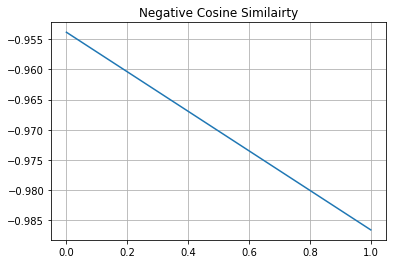

In [ ]:
EPOCHS = 2
num_training_samples = len(x_train)
steps = EPOCHS * ( num_training_samples // BATCH_SIZE)

lr_decayed_fn = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=0.03, decay_steps=steps
)

# Create an early stopping callback.
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="loss", patience=5, restore_best_weights=True
)

# Compile model and start training.
Final_Training_Model = SSL_DWT( encoder_dwt() , predictor_dwt() )
Final_Training_Model.compile(optimizer=tf.keras.optimizers.SGD(lr_decayed_fn, momentum=0.6))
history = Final_Training_Model.fit(ssl_ds_rs , epochs=EPOCHS , callbacks=[early_stopping])

# Visualize the training progress of the model.
plt.plot(history.history["loss"])
plt.grid()
plt.title("Negative Cosine Similairty")
plt.show()

Now we Evaluate the Performance of our Model using the test dataset and training on the train dataset

In [ ]:
#This Block is used for reference(We have tested with the original ssl_ds dataset on the model)
#Do Not Run
# We first create labeled `Dataset` objects.
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))

# Then we shuffle, batch, and prefetch this dataset for performance. We
# also apply random resized crops as an augmentation but only to the
# training set.
train_ds = (train_ds.shuffle(1024).map(lambda x, y: (flip_random_crop(x), y), num_parallel_calls=AUTO).batch(BATCH_SIZE).prefetch(AUTO))
test_ds = test_ds.batch(BATCH_SIZE).prefetch(AUTO)

#Evaluation_Model =  tf.keras.Sequential(
 #  [ 
  #   tf.keras.layers.Input((CROP_TO,CROP_TO,3)),
   #  #tf.keras.models.Model([
    # Final_Training_Model.encoder.input,
     #tf.keras.layers.Dense(10,activation="softmax")
   #]
#)
# Extract the backbone ResNet50
backbone = tf.keras.Sequential([Final_Training_Model.encoder.get_layer('input_9'),Final_Training_Model.encoder.get_layer("resnet50")])

# We then create our linear classifier and train it.
backbone.trainable = False
inputs = layers.Input((CROP_TO, CROP_TO, 3))
#The Trained weights of the resnet layer is stored in x.
x = backbone(inputs, training=False)
#Then the x is the passed into a Dense layer with softmax activation function to get the final layer's weights.
outputs = layers.Dense(10, activation="softmax")(x)
#We now proceed to build our final linear model
linear_model = tf.keras.Model(inputs, outputs, name="linear_model")

# Compile model and start training.
linear_model.compile(loss="sparse_categorical_crossentropy",metrics=["accuracy"],optimizer=tf.keras.optimizers.SGD(lr_decayed_fn, momentum=0.9),)
history = linear_model.fit(train_ds, validation_data=test_ds, epochs=EPOCHS, callbacks=[early_stopping]),
test_acc = linear_model.evaluate(test_ds)
#print("Test accuracy: {:.2f}%".format(test_acc * 100))

Epoch 1/5
782/782 [==============================] - 17s 18ms/step - loss: 13525.1660 - accuracy: 0.1169 - val_loss: 15346.0430 - val_accuracy: 0.1186
Epoch 2/5
782/782 [==============================] - 14s 18ms/step - loss: 7966.3750 - accuracy: 0.1425 - val_loss: 4788.8965 - val_accuracy: 0.1548
Epoch 3/5
782/782 [==============================] - 14s 17ms/step - loss: 3042.1628 - accuracy: 0.1839 - val_loss: 3461.6433 - val_accuracy: 0.1097
Epoch 4/5
782/782 [==============================] - 13s 17ms/step - loss: 779.3660 - accuracy: 0.2661 - val_loss: 454.8718 - val_accuracy: 0.2908
Epoch 5/5
157/157 [==============================] - 2s 13ms/step - loss: 319.7362 - accuracy: 0.3419


In [ ]:
print("Test accuracy: {:.2f}%".format(test_acc[1] * 100))

Test accuracy: 34.19%


In [ ]:
test_acc

[319.7361755371094, 0.3418999910354614]

We test our model after applying dwt.Ideally we would expect the accuracy to increase from 34.19%.

In [ ]:
EPOCHS = 6
# We first create labeled `Dataset` objects.
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))

# Then we shuffle, batch, and prefetch this dataset for performance. We
# also apply random resized crops as an augmentation but only to the
# training set.
train_ds = (train_ds.shuffle(1024).map(lambda x, y: (flip_random_crop(x), y), num_parallel_calls=AUTO).batch(BATCH_SIZE).prefetch(AUTO))
test_ds = test_ds.batch(BATCH_SIZE).prefetch(AUTO)

#Evaluation_Model =  tf.keras.Sequential(
 #  [ 
  #   tf.keras.layers.Input((CROP_TO,CROP_TO,3)),
   #  #tf.keras.models.Model([
    # Final_Training_Model.encoder.input,
     #tf.keras.layers.Dense(10,activation="softmax")
   #]
#)
# Extract the backbone ResNet50
backbone = tf.keras.Sequential([tf.keras.layers.Input((CROP_TO, CROP_TO, 3)),
                                tf.keras.layers.InputLayer(input_shape = (WIDTH,HEIGHT,3)),
                                Final_Training_Model.encoder.get_layer("resnet50")])

# We then create our linear classifier and train it.
backbone.trainable = False
inputs = layers.Input((CROP_TO, CROP_TO, 3))
#The Trained weights of the resnet layer is stored in x.
x = backbone(inputs, training=False)
#Then the x is the passed into a Dense layer with softmax activation function to get the final layer's weights.
outputs = layers.Dense(10, activation="softmax")(x)
#We now proceed to build our final linear model
linear_model = tf.keras.Model(inputs, outputs, name="linear_model")

# Compile model and start training.
linear_model.compile(loss="sparse_categorical_crossentropy",metrics=["accuracy"],optimizer=tf.keras.optimizers.SGD(lr_decayed_fn, momentum=0.9),)
history = linear_model.fit(train_ds, validation_data=test_ds, epochs=EPOCHS, callbacks=[early_stopping]),
test_acc = linear_model.evaluate(test_ds)
#print("Test accuracy: {:.2f}%".format(test_acc * 100))

Epoch 1/6
782/782 [==============================] - 195s 246ms/step - loss: 640.0529 - accuracy: 0.1820 - val_loss: 137.1362 - val_accuracy: 0.2648
Epoch 2/6
782/782 [==============================] - 176s 225ms/step - loss: 69.6294 - accuracy: 0.3448 - val_loss: 36.5943 - val_accuracy: 0.3993
Epoch 3/6
782/782 [==============================] - 160s 205ms/step - loss: 36.2232 - accuracy: 0.3977 - val_loss: 36.5821 - val_accuracy: 0.3994
Epoch 4/6
782/782 [==============================] - 160s 205ms/step - loss: 36.0701 - accuracy: 0.4022 - val_loss: 36.5821 - val_accuracy: 0.3994
Epoch 5/6
782/782 [==============================] - 160s 205ms/step - loss: 36.2313 - accuracy: 0.3976 - val_loss: 36.5821 - val_accuracy: 0.3994
Epoch 6/6
157/157 [==============================] - 27s 171ms/step - loss: 36.5821 - accuracy: 0.3994


In [ ]:
print("Test accuracy: {:.2f}%".format(test_acc[1] * 100))

Test accuracy: 39.94%


In [ ]:
test_acc

[36.58209228515625, 0.399399995803833]

We can see that the accuracy as well as the validation accuracy has increased and the loss has also decreased drastically.But the accuracy has stagnated at over 40% but still it has increased from an accuracy of 
34.19% without dwt.So we can safely say that doing **Discrete Wavaelet Transformation (DWT)** has worked well for our model.

Now we proceed to save our model for future purposes

In [ ]:
linear_model.save_weights('./checkpoints/my_checkpoint')

In [ ]:
linear_model.save_weights('./checkpoints/my_linear_model.pb')

Now we are gonna test if the save has been sucessful by loading the model and evaluating again

In [ ]:
Final_Training_Model.save_weights('./checkpoints/my_checkpoint')

In [ ]:
Evaluation_Model = SSL_DWT(encoder_dwt() , predictor_dwt())
Evaluation_Model.load_weights('./checkpoints/my_checkpoint')

In [ ]:
EPOCHS_TEST = 2
# We first create labeled `Dataset` objects.
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))

# Then we shuffle, batch, and prefetch this dataset for performance. We
# also apply random resized crops as an augmentation but only to the
# training set.
train_ds = (train_ds.shuffle(1024).map(lambda x, y: (flip_random_crop(x), y), num_parallel_calls=AUTO).batch(BATCH_SIZE).prefetch(AUTO))
test_ds = test_ds.batch(BATCH_SIZE).prefetch(AUTO)

#Evaluation_Model =  tf.keras.Sequential(
 #  [ 
  #   tf.keras.layers.Input((CROP_TO,CROP_TO,3)),
   #  #tf.keras.models.Model([
    # Final_Training_Model.encoder.input,
     #tf.keras.layers.Dense(10,activation="softmax")
   #]
#)
# Extract the backbone ResNet50
backbone = tf.keras.Sequential([tf.keras.layers.Input((CROP_TO, CROP_TO, 3)),
                                tf.keras.layers.InputLayer(input_shape = (WIDTH,HEIGHT,3)),
                                Evaluation_Model.encoder.get_layer("resnet50")])

# We then create our linear classifier and train it.
backbone.trainable = False
inputs = layers.Input((CROP_TO, CROP_TO, 3))
#The Trained weights of the resnet layer is stored in x.
x = backbone(inputs, training=False)
#Then the x is the passed into a Dense layer with softmax activation function to get the final layer's weights.
outputs = layers.Dense(10, activation="softmax")(x)
#We now proceed to build our final linear model
linear_model_test = tf.keras.Model(inputs, outputs, name="linear_model")

# Compile model and start training.
linear_model_test.compile(loss="sparse_categorical_crossentropy",metrics=["accuracy"],optimizer=tf.keras.optimizers.SGD(lr_decayed_fn, momentum=0.9),)
history = linear_model_test.fit(train_ds, validation_data=test_ds, epochs=EPOCHS_TEST, callbacks=[early_stopping]),
test_acc = linear_model_test.evaluate(test_ds)
#print("Test accuracy: {:.2f}%".format(test_acc * 100))

Epoch 1/2
782/782 [==============================] - 192s 242ms/step - loss: 614.4282 - accuracy: 0.1855 - val_loss: 172.2503 - val_accuracy: 0.2562
Epoch 2/2
157/157 [==============================] - 32s 201ms/step - loss: 33.4424 - accuracy: 0.3991


We can see that the saving model of process is sucessful.

We now save the entire linear model.We wont be able to save Final Training Model because it is a class.But we can save the backbone model.We will be saving linear model and backbone model.

In [ ]:
# Save the entire model as a SavedModel.
!mkdir -p saved_model
linear_model.save('saved_model/my_linear_model') 

In [ ]:
!mkdir -p backbone_saved_model
backbone.save('saved_model/backbone_model') 

In [ ]:
#!mkdir -p saved_model
#Evaluation_Model.save('saved_model/Final_Training_Model')

In [ ]:
#Run this block to download the model file into your Laptop
from google.colab import files
files.download('/content/saved_model/my_linear_model/saved_model.pb') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import files
files.download('/content/saved_model/backbone_model/saved_model.pb') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#Saving in H5 format
backbone.save('my_backbone_model.h5')

In [ ]:
linear_model.save('my_linear_model.h5')

In [ ]:
#Run this block to download the model file into your Laptop
from google.colab import files
files.download('/content/my_backbone_model.h5') 

from google.colab import files
files.download('/content/my_linear_model.h5') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import files
files.download('/content/my_linear_model.h5') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import files
files.download('/content/checkpoints/my_linear_model.pb.data-00000-of-00001') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
backbone_new = tf.keras.models.load_model('/my_linear_model.h5')

**THE SSL MODEL CODE ENDS HERE**

**MISCELLANEOUS CODE BLOCKS FOR REFRENCE --- DO NOT RUN**

In [ ]:
sample_data = np.ones((4,4), dtype=np.float64)
coeffs = pywt.dwt2(sample_data, 'haar')
cA, (cH, cV, cD) = coeffs

In [ ]:
cA

array([[2., 2.],
       [2., 2.]])

In [ ]:
cH

array([[0., 0.],
       [0., 0.]])

In [ ]:
cV

array([[0., 0.],
       [0., 0.]])

In [ ]:
cD

array([[0., 0.],
       [0., 0.]])

Other Miscellaneous code blocks.


In [ ]:
zz = tf.data.Dataset.from_tensor_slices(x_train)

In [ ]:
list1 = [ ]
for i in ssl_ds_one_gs.take(1):
  list1.append(i)

In [ ]:
list1 = [ ]
for i in ssl_ds_two.take(-1):
  list1.append(np.array(i))
list1[0].shape
list1 = np.array(list1)

In [ ]:
x_train_grayscale = [ ]
for i in range(len(x_train)):
  x_train_grayscale.append(cv2.cvtColor(x_train[i], cv2.COLOR_BGR2GRAY))

In [ ]:
x_train_grayscale = np.array(x_train_grayscale)

In [ ]:
x_train_grayscale.shape

(50000, 32, 32)

In [ ]:
50000/100

500.0

In [ ]:
#Model Code Block -- Do not run
D_V1 = []
D_V2 = []
n = 0
m = 99
c = int(50000/100)

for j in range(c):
  for i in range(n,m):
    temp = x_train[i]
    one = custom_augment(temp)
    D_V1.append(one)
    two = custom_augment(temp)
    D_V2.append(two)
  n = n + 100
  m = m + 100

In [ ]:
#Model Code Block -- Do not run
#Adding the last 500 images to the Dataset as well
for i in range(49500,50000):
   temp = x_train[i]
   one = custom_augment(temp)
   D_V1.append(np.array(one))
   two = custom_augment(temp)
   D_V2.append(np.array(two))

Due to our Resource Constraint we take only first 500 images for pretraining.

In [ ]:
D_V1 = []
D_V2 = []
n = 0
m = 99
c = int(500/100)

for j in range(c):
  for i in range(n,m):
    temp = x_train[i]
    one = custom_augment(temp)
    D_V1.append(one)
    two = custom_augment(temp)
    D_V2.append(two)
  n = n + 100
  m = m + 100

In [ ]:
np.array(D_V1).shape

(495, 32, 32, 3)

In [ ]:
#Adding the last 5 images to the Dataset as well
for i in range(495,500):
   temp = x_train[i]
   one = custom_augment(temp)
   D_V1.append(np.array(one))
   two = custom_augment(temp)
   D_V2.append(np.array(two))

In [ ]:
x_train.shape

(50000, 32, 32, 3)

In [ ]:
type(np.array(D_V1[0]))

numpy.ndarray

In [ ]:
for i in range(len(D_V1)):
  D_V1[i] = np.array(D_V1[i])
  D_V2[i] = np.array(D_V2[i])

In [ ]:
D_V1 = list(D_V1)
D_V2 = list(D_V2)

In [ ]:
D_V1 = np.array(D_V1)
D_V2 = np.array(D_V2)

In [ ]:
#Now we convert all the images to grayscale before passing it to the model
D_V1_GS = [ ]
D_V2_GS = [ ]
for i in range(len(D_V1)):
  D_V1_GS.append(cv2.cvtColor(D_V1[i], cv2.COLOR_BGR2GRAY))
  D_V2_GS.append(cv2.cvtColor(D_V2[i], cv2.COLOR_BGR2GRAY))

In [ ]:
D_V1_GS = np.array(D_V1_GS)
D_V2_GS = np.array(D_V2_GS)
D_V1_GS.shape

(500, 32, 32)

In [ ]:
DS1_GS = [ ]
DS2_GS = [ ]
n = 0
m = 99
c = int(500/100) 
#c = int(1000/100) + 1
for j in range(c):
  for i in range(n,m):
    img1 = cv2.resize(D_V1_GS[i],(64,64))
    img1 = img1.reshape((64,64,1))
    img2 = cv2.resize(D_V2_GS[i],(64,64))
    img2 = img2.reshape((64,64,1))
    DS1_GS.append(img1)
    DS2_GS.append(img2)
  n = n + 100
  m = m + 100

DS1_GS = np.array(DS1_GS)
DS2_GS = np.array(DS2_GS)
DS1_GS.shape

(495, 64, 64, 1)

In [ ]:
#Adding the last 5 images
DS1_GS = list(DS1_GS)
DS2_GS = list(DS2_GS)
for i in range(495,500):
    img1 = cv2.resize(D_V1_GS[i],(64,64))
    img1 = img1.reshape((64,64,1))
    img2 = cv2.resize(D_V2_GS[i],(64,64))
    img2 = img2.reshape((64,64,1))
    DS1_GS.append(img1)
    DS2_GS.append(img2) 

DS1_GS = np.array(DS1_GS)
DS2_GS = np.array(DS2_GS) 
DS1_GS.shape

(500, 64, 64, 1)

In [ ]:
ssl_ds_pretrain_dwt = zip(DS1_GS , DS2_GS)

In [ ]:
DS1 = [ ]
DS2 = [ ]
n = 0
m = 99
c = int(500/100) 
#c = int(1000/100) + 1
for j in range(c):
  for i in range(n,m):
    ds_one_modes = pywt.dwt2(D_V1_GS[i], 'haar')
    ds_two_modes = pywt.dwt2(D_V2_GS[i], 'haar')
    d1_A, (d1_H, d1_V, d1_D) = ds_one_modes
    d2_A, (d2_H, d2_V, d2_D) = ds_one_modes
    d1_A = cv2.resize(d1_A,(32,32))
    d1_H = cv2.resize(d1_H,(32,32))
    d1_V = cv2.resize(d1_V,(32,32))
    d1_D = cv2.resize(d1_D,(32,32))
    d2_A = cv2.resize(d2_A,(32,32))
    d2_H = cv2.resize(d2_H,(32,32))
    d2_V = cv2.resize(d2_V,(32,32))
    d2_D = cv2.resize(d2_D,(32,32))

    val1 = [ ]
    val1.append(d1_A)
    val1.append(d1_H)
    val1.append(d1_V)
    val1.append(d1_D)
    DS1.append(val1)

    val2 = [ ]
    val2.append(d2_A)
    val2.append(d2_H)
    val2.append(d2_V)
    val2.append(d2_D)
    DS2.append(val2)
  n = n + 100
  m = m + 100

DS1 = np.array(DS1)
DS2 = np.array(DS2)
DS1.shape

(495, 4, 32, 32)

In [ ]:
#Adding the last 5 images
DS1 = list(DS1)
DS2 = list(DS2)
for i in range(495,500):
    ds_one_modes = pywt.dwt2(D_V1_GS[i], 'haar')
    ds_two_modes = pywt.dwt2(D_V2_GS[i], 'haar')
    d1_A, (d1_H, d1_V, d1_D) = ds_one_modes
    d2_A, (d2_H, d2_V, d2_D) = ds_one_modes
    d1_A = cv2.resize(d1_A,(32,32))
    d1_H = cv2.resize(d1_H,(32,32))
    d1_V = cv2.resize(d1_V,(32,32))
    d1_D = cv2.resize(d1_D,(32,32))
    d2_A = cv2.resize(d2_A,(32,32))
    d2_H = cv2.resize(d2_H,(32,32))
    d2_V = cv2.resize(d2_V,(32,32))
    d2_D = cv2.resize(d2_D,(32,32))

    val1 = [ ]
    val1.append(d1_A)
    val1.append(d1_H)
    val1.append(d1_V)
    val1.append(d1_D)
    DS1.append(val1)

    val2 = [ ]
    val2.append(d2_A)
    val2.append(d2_H)
    val2.append(d2_V)
    val2.append(d2_D)
    DS2.append(val2)

DS1 = np.array(DS1)
DS2 = np.array(DS2)
DS1.shape

(500, 4, 32, 32)

Now we take a closer look at the data and then do some necessary preprocessing to the dwt transformed images

In [ ]:
DS1[0][0].shape

(32, 32)

In [ ]:
var = DS1[0][0].reshape((32,32,1))
#bcrgb = cv2.cvtColor(var,cv2.COLOR_GRAY2RGB)
var.shape

(32, 32, 1)

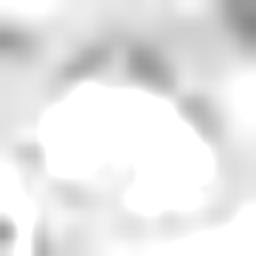

In [ ]:
from google.colab.patches import cv2_imshow
sample = cv2.resize(var,(256,256))
cv2_imshow(sample)

In [ ]:
gray_three = cv2.merge([var,var,var])

In [ ]:
gray_three.shape

(32, 32, 3)

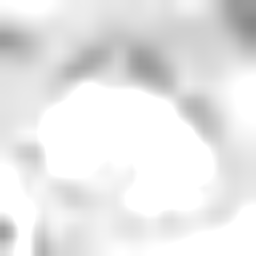

In [ ]:
sample = cv2.resize(gray_three,(256,256))
cv2_imshow(sample)

In [ ]:
sample.shape

(256, 256, 3)

In [ ]:
#Reshaping the Images to (32,32,3)
ds1 = []
ds2 = []
n = 0 
m = 99
#c = int(50000/100)
c = int(len(DS1)/100) 
for j in range(c):
  for i in range(n,m):
    temp1 = []
    temp2 = []
    for k in range(4):
      var1 = DS1[i][k]
      var2 = DS2[i][k]
      #ds1.append(cv2.cvtColor(DS1[i][k],cv2.COLOR_GRAY2RGB))
      #ds2.append(cv2.cvtColor(DS2[i][k],cv2.COLOR_GRAY2RGB))
      temp1.append(cv2.merge([var1,var1,var1]))
      temp2.append(cv2.merge([var2,var2,var2]))
    ds1.append(temp1)
    ds2.append(temp2)

In [ ]:
len(ds1[0])

4

In [ ]:
np.array(ds1).shape

(495, 4, 32, 32, 3)

In [ ]:
#Adding last 5 images
for i in range(495,500):
    temp1 = []
    temp2 = []
    for k in range(4):
      var1 = DS1[i][k]
      var2 = DS2[i][k]
      #ds1.append(cv2.cvtColor(DS1[i][k],cv2.COLOR_GRAY2RGB))
      #ds2.append(cv2.cvtColor(DS2[i][k],cv2.COLOR_GRAY2RGB))
      temp1.append(cv2.merge([var1,var1,var1]))
      temp2.append(cv2.merge([var2,var2,var2]))
    ds1.append(temp1)
    ds2.append(temp2)

In [ ]:
ds1 = np.array(ds1)
ds2 = np.array(ds2)

In [ ]:
ds1.shape

(500, 4, 32, 32, 3)

Splitting our dataset into four

In [ ]:
d1_A = []
d1_H = []
d1_V = []
d1_D = []
d2_A = []
d2_H = []
d2_V = []
d2_D = []
for i in range(len(ds1)):
  temp_1 = ds1[i]
  temp_2 = ds2[i]
  d1_A.append(temp_1[0])
  d1_H.append(temp_1[1])
  d1_V.append(temp_1[2])
  d1_D.append(temp_1[3])
  d2_A.append(temp_2[0])
  d2_H.append(temp_2[1])
  d2_V.append(temp_2[2])
  d2_D.append(temp_2[3])

d1_A = np.array(d1_A)
d1_H = np.array(d1_H)
d1_V = np.array(d1_V)
d1_D = np.array(d1_D)
d2_A = np.array(d2_A)
d2_H = np.array(d2_H)
d2_V = np.array(d2_V)
d2_D = np.array(d2_D)

In [ ]:
d1_A.shape

(500, 32, 32, 3)

Zipping Our Final Dataset

In [ ]:
ssl_ds_pretrain = zip(ds1 , ds2)

In [ ]:
ssl_ds_pretrain

ERROR DEBUGGING and MISCELLANEOUS CODE BLOCKS FOR REFERENCE

In [ ]:
l1,l2 = zip(*ssl_ds_pretrain_dwt)

In [ ]:
encoder_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       multiple                  0         
                                                                 
 haar (DWT)                  (None, 32, 32, 4)         0         
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 3)         195       
                                                                 
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense_5 (Dense)             (None, 2048)              4196352   
                                                                 
 dense_6 (Dense)             (None, 2048)              4194304   
                                                                 
 batch_normalization_3 (Batc  (None, 2048)             8

Epoch 1/5


16/16 [==============================] - 3s 20ms/step - loss: 2.4545
Epoch 2/5
16/16 [==============================] - 0s 14ms/step - loss: 2.4487
Epoch 3/5
16/16 [==============================] - 0s 13ms/step - loss: 2.4428
Epoch 4/5
16/16 [==============================] - 0s 13ms/step - loss: 2.4370
Epoch 5/5
16/16 [==============================] - 0s 14ms/step - loss: 2.4312


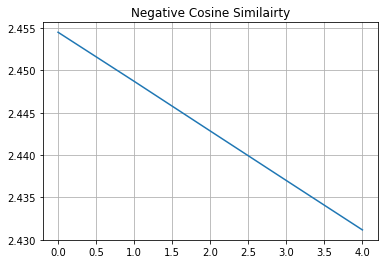

In [ ]:
EPOCHS = 5
num_training_samples = len(x_train)
steps = EPOCHS * ( num_training_samples // BATCH_SIZE)

lr_decayed_fn = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=0.03, decay_steps=steps
)

# Create an early stopping callback.
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="loss", patience=5, restore_best_weights=True
)

# Compile model and start training.
#Final_Training_Model = encoder_model()
encoder_model.compile(optimizer=tf.keras.optimizers.SGD(lr_decayed_fn, momentum=0.6))
history = encoder_model.fit(DS1_GS,DS2_GS , epochs=EPOCHS )
#, callbacks=[early_stopping])

# Visualize the training progress of the model.
plt.plot(history.history["loss"])
plt.grid()
plt.title("Negative Cosine Similairty")
plt.show()

In [ ]:
input_shape_gs = (None,32,32,1)
dummy_model = tf.keras.Sequential(
           [ 
             # Input and backbone.
             tf.keras.layers.Input((CROP_TO_DWT, CROP_TO_DWT, 3)),
             tf.keras.layers.InputLayer(input_shape = (WIDTH_DWT,HEIGHT_DWT,3)),
             tf.keras.layers.Conv2D(1, 3,activation='relu',padding="same",input_shape=input_shape_gs[1:]),
             DWT.DWT(name="haar",concat=0),
             tf.keras.layers.Conv2D(3, 4,activation='relu',padding="same",input_shape=input_shape[1:]),
             tf.keras.applications.ResNet50(input_shape=(WIDTH, HEIGHT , 3 ),weights=None, include_top=False, pooling='avg'), 
             tf.keras.layers.Dense(PROJECT_DIM),

             # Projection head.
             tf.keras.layers.Dense(PROJECT_DIM,use_bias=False,kernel_regularizer=regularizers.l2(WEIGHT_DECAY)),
             tf.keras.layers.BatchNormalization(),
             tf.keras.layers.ReLU(),
             tf.keras.layers.Dense(PROJECT_DIM,use_bias=False,kernel_regularizer=regularizers.l2(WEIGHT_DECAY)),
             tf.keras.layers.BatchNormalization(),

             #Predictor
             tf.keras.layers.Input((PROJECT_DIM,)),
             tf.keras.layers.Dense(LATENT_DIM,use_bias=False,kernel_regularizer=regularizers.l2(WEIGHT_DECAY),),
             tf.keras.layers.ReLU(),
             tf.keras.layers.BatchNormalization(),
             tf.keras.layers.Dense(PROJECT_DIM),
           ] )

In [ ]:
dummy_model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_79 (InputLayer)       multiple                  0         
                                                                 
 conv2d_19 (Conv2D)          (None, 64, 64, 1)         28        
                                                                 
 haar (DWT)                  (None, 32, 32, 4)         0         
                                                                 
 conv2d_20 (Conv2D)          (None, 32, 32, 3)         195       
                                                                 
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense_71 (Dense)            (None, 2048)              4196352   
                                                                 
 dense_72 (Dense)            (None, 2048)            

In [ ]:
EPOCHS = 5
BATCH_SIZE = 100
num_training_samples = len(ds1)
steps = EPOCHS * ( num_training_samples // BATCH_SIZE)
steps

25

In [ ]:
#def flip_random_crop_dwt(image):
    # With random crops we also apply horizontal flipping.
 #   image = tf.image.random_flip_left_right(image)
  #  image = tf.image.random_crop(image, (CROP_TO, CROP_TO, 3))
   # return image


#def color_jitter(image, strength=[0.4, 0.4, 0.4, 0.1]):
 #   image = tf.image.random_brightness(image, max_delta=0.8 * strength[0])
  #  image = tf.image.random_contrast(image, lower=1 - 0.8 * strength[1], upper=1 + 0.8 * strength[1])
   # image = tf.image.random_saturation(image, lower=1 - 0.8 * strength[2], upper=1 + 0.8 * strength[2])
    #image = tf.image.random_hue(image, max_delta=0.2 * strength[3])
    # Affine transformations can disturb the natural range of
    # RGB images, hence this is needed.
    #image = tf.clip_by_value(image, 0, 255)
    #return image


#def color_drop(image):
 #   image = tf.image.rgb_to_grayscale(image)
    #image = tf.tile(image, [1, 1, 3])
  #  return image


#def random_apply(func, image, p):
 #   if tf.random.uniform([], minval=0, maxval=1) < p:
  #      return func(image)
   # else:
    #    return image

#def convert_to_grayscale(image):
 # image = np.array(image) 
  #image_grayscale = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  #return image_grayscale

#def custom_augment_dwt(image):
    # As discussed in the SimCLR paper, the series of augmentation
    # transformations (except for random crops) need to be applied
    # randomly to impose translational invariance.
    #image = flip_random_crop_dwt(image)
    #image = random_apply(color_jitter, image, p=0.8)
    #image = random_apply(color_drop, image, p=0.2)
    #image = dwt_D(image)
    #return image 

Stop Iteration Error Debugging

It was identified that the Stop Iteration Error was occuring due to the decay_steps being set to a value which was'nt compatible with the our dataset size.So we modified the step part to fix this error

In [ ]:
D1 , D2 = zip(*ssl_ds_pretrain)

In [ ]:
Dataset1 = np.array(ds1)
Dataset2 = np.array(ds2)
d1_A = []
d1_H = []
d1_V = []
d1_D = []
d2_A = []
d2_H = []
d2_V = []
d2_D = []
for i in range(len(Dataset1)):
  temp_1 = Dataset1[i]
  temp_2 = Dataset2[i]
  d1_A.append(np.array(temp_1[0]))
  d1_H.append(np.array(temp_1[1]))
  d1_V.append(np.array(temp_1[2]))
  d1_D.append(np.array(temp_1[3]))
  d2_A.append(np.array(temp_2[0]))
  d2_H.append(np.array(temp_2[1]))
  d2_V.append(np.array(temp_2[2]))
  d2_D.append(np.array(temp_2[3]))

In [ ]:
np.array(d1_A).shape

(500, 32, 32, 3)

In [ ]:
type(d1_A)

list

Zipping Error Debugging

In [ ]:
sample = zip(D_V1_GS[0] , D_V2_GS[0])

In [ ]:
class Final_Model_DWT(tf.keras.Model):
    def __init__(self,encoder,predictor):
        super(Final_Model_DWT,self).__init__()
        #self.model = model
        self.encoder = encoder
        self.predictor = predictor
        self.loss_tracker = tf.keras.metrics.Mean(name="loss")

    @property
    def metrics(self):
        return [self.loss_tracker]

    def train_step(self , data):
        # Unpack the data .
        Dataset1 , Dataset2 = zip(*data)
        Dataset1 = np.array(Dataset1)
        Dataset2 = np.array(Dataset2)
        # Forward pass through the encoder and predictor.
        try:
          with tf.GradientTape() as tape:
            z1_A , z2_A = self.encoder(d1_A), self.encoder(d2_A)
            z1_H , z2_H = self.encoder(d1_H), self.encoder(d2_H)
            z1_V , z2_V = self.encoder(d1_V), self.encoder(d2_V)
            z1_D , z2_D = self.encoder(d1_D), self.encoder(d2_D)
            #Now we proceed to predictor's output
            #p1 , p2 = self.predictor(z1), self.predictor(z2)
            p1_A , p2_A = self.predictor(z1_A) , self.predictor(z2_A)
            p1_H , p2_H = self.predictor(z1_H) , self.predictor(z2_H)
            p1_V , p2_V = self.predictor(z1_V) , self.predictor(z2_V)
            p1_D , p2_D = self.predictor(z1_D) , self.predictor(z2_D) 
            # Note that here we are enforcing the network to match
            # the representations of two differently augmented batches of data.
            #Now we calculate the loss
            #We calculate the A mode's loss
            loss_A = cosine_similarity(p1_A, z2_A)  
            loss_A += cosine_similarity(p2_A, z1_A) 
            loss_A = loss_A/2
            #We calculate the A mode's loss
            loss_H = cosine_similarity(p1_H, z2_H)  
            loss_H += cosine_similarity(p2_H, z1_H) 
            loss_H = loss_H/2
            #We calculate the A mode's loss
            loss_V = cosine_similarity(p1_V, z2_V)  
            loss_V += cosine_similarity(p2_V, z1_V) 
            loss_V = loss_V/2
            #We calculate the A mode's loss
            loss_D = cosine_similarity(p1_D, z2_D)  
            loss_D += cosine_similarity(p2_D, z1_D) 
            loss_D = loss_D/2
            #Now we compute the final loss
            loss = loss_A + loss_H + loss_V + loss_D

        except StopIteration:
          print("Done")
         # exit(2)
        # Compute gradients and update the parameters.
        learnable_params = (
            self.encoder.trainable_variables + self.predictor.trainable_variables
        )
        gradients = tape.gradient(loss, learnable_params)
        self.optimizer.apply_gradients(zip(gradients, learnable_params))

        # Monitor loss.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

In [ ]:
D_V1[0].shape

(32, 32, 3)

In [ ]:
listA , listB = zip(*sample)

In [ ]:
listA = np.array(listA)

In [ ]:
listA.shape

(32, 32)

In [ ]:
listA[0].shape

(32,)

In [ ]:
one_modes = pywt.dwt2(D_V1_GS[0], 'haar')
d1_A, (d1_H, d1_V, d1_D) = one_modes

In [ ]:
d1_a = d1_A.reshape((16,16,1))

In [ ]:
d1_a = cv2.resize(d1_a,(32,32))

In [ ]:
d1_a.shape

(32, 32)

In [ ]:
DS1 = list(DS1)

In [ ]:
aa = DS1[0]
type(aa)

numpy.ndarray

In [ ]:
a = aa[0]

In [ ]:
a = a.reshape((16,16,1))

In [ ]:
a.shape

(16, 16, 1)

In [ ]:
ds1 = DS1

In [ ]:
for i in range(1):
  aa = DS1[i]
  temp = [ ]
  for j in range(len(aa)):
    a = aa[j]
    a = a.reshape((16,16,1))
    a = cv2.resize(a,(32,32))
    temp.append(a)
  ds1[i] = temp

In [ ]:
ds1[0][0].shape

(32, 32)

In [ ]:
ds_1 = [ ]

In [ ]:
np.array(ds_1).shape

(50000, 4, 32, 32)

In [ ]:
DS1[0][0].shape

(32, 32)

In [ ]:
for i in range(len(DS1))

In [ ]:
for i in range(len(DS2)):
  aa = DS2[i]
  temp = [ ]
  for j in range(len(aa)):
    a = aa[j]
    a = a.reshape((16,16,1))
    temp.append(a)
  DS2[i] = temp

In [ ]:
len(DS1[0])

4

In [ ]:
ds_one = D_V1_GS
ds_two = D_V2_GS
ds_one_modes = pywt.dwt2(ds_one, 'haar')
ds_two_modes = pywt.dwt2(ds_two, 'haar')
d1_A, (d1_H, d1_V, d1_D) = ds_one_modes
d2_A, (d2_H, d2_V, d2_D) = ds_one_modes

In [ ]:
d1_A[0].shape

(16, 16)

In [ ]:
d1A = [ ]
for i in range(len(d1_A)):
  a = d1_A[i] 
  a = a.reshape((16,16,1))  
  a = cv2.resize(a,(32,32))
  d1A.append(a)

In [ ]:
d1A = [ ]
d2A = [ ]
for i in range(len(d1_A)):
  aa = d1_A[i] 
  aa = aa.reshape((16,16,1))  
  a = cv2.resize(aa,(32,32))
  #a = cv2.cvtColor(aa , cv2.COLOR_GRAY2RGB)
  d1A.append(a)

  bb = d2_A[i] 
  bb = bb.reshape((16,16,1))  
  b = cv2.resize(bb,(32,32))
  #b = cv2.cvtColor(bb , cv2.COLOR_GRAY2RGB)
  d2A.append(b)

d1A = np.array(d1A)
d2A = np.array(d2A)

In [ ]:
d1A.shape

(50000, 32, 32)

In [ ]:
dummy_model = tf.keras.Sequential([tf.keras.layers.Input((64, 64, 1)),
                                   tf.keras.layers.InputLayer(input_shape = (64,64,1)),
                                   #DWT.DWT(name="haar",concat=0),
                                   DWT.DWT(name="haar",concat = 0),
                                   #tf.keras.layers.Flatten(),
                                   tf.keras.applications.ResNet50(input_shape=(32,32,4),weights=None, include_top=False, pooling='avg'), 
                                   #tf.keras.layers.Reshape((2048,))
                                   ])
dummy_model.summary()

/usr/local/lib/python3.9/dist-packages/keras/applications/resnet.py:159: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 4 input channels.
  input_shape = imagenet_utils.obtain_input_shape(


Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_34 (InputLayer)       multiple                  0         
                                                                 
 haar (DWT)                  (None, 32, 32, 4)         0         
                                                                 
 resnet50 (Functional)       (None, 2048)              23590848  
                                                                 
Total params: 23,590,848
Trainable params: 23,537,728
Non-trainable params: 53,120
_________________________________________________________________


In [ ]:
d1H = [ ]
d2H = [ ]
for i in range(len(d1_H)):
  aa = d1_H[i] 
  aa = aa.reshape((16,16,1))  
  a = cv2.resize(aa,(32,32))
  #a = cv2.cvtColor(aa , cv2.COLOR_GRAY2RGB)
  d1H.append(a)

  bb = d2_H[i] 
  bb = bb.reshape((16,16,1))  
  b = cv2.resize(bb,(32,32))
  #b = cv2.cvtColor(bb , cv2.COLOR_GRAY2RGB)
  d2H.append(b)

d1H = np.array(d1H)
d2H = np.array(d2H)

In [ ]:
d1V = [ ]
d2V = [ ]
for i in range(len(d1_V)):
  aa = d1_V[i] 
  aa = aa.reshape((16,16,1))  
  a = cv2.resize(aa,(32,32))
  #a = cv2.cvtColor(aa , cv2.COLOR_GRAY2RGB)
  d1V.append(a)

  bb = d2_V[i] 
  bb = bb.reshape((16,16,1))  
  b = cv2.resize(bb,(32,32))
  #b = cv2.cvtColor(bb , cv2.COLOR_GRAY2RGB)
  d2V.append(b)

d1V = np.array(d1V)
d2V = np.array(d2V)

In [ ]:
d1D = [ ]
d2D = [ ]
for i in range(len(d1_D)):
  aa = d1_D[i] 
  aa = aa.reshape((16,16,1))  
  a = cv2.resize(aa,(32,32))
  #a = cv2.cvtColor(aa , cv2.COLOR_GRAY2RGB)
  d1D.append(a)

  bb = d2_D[i] 
  bb = bb.reshape((16,16,1))  
  b = cv2.resize(bb,(32,32))
  #b = cv2.cvtColor(bb , cv2.COLOR_GRAY2RGB)
  d2D.append(b)

d1D = np.array(d1D)
d2D = np.array(d2D)

In [ ]:
list_ds1 = [ ]
list_ds1.append(cv2.resize(d1_A,(32,32)))
#list_ds1.append(d1_H)
#list_ds1.append(d1_V)
#list_ds1.append(d1_D)

#list_ds2 = [ ]
#list_ds2.append(d2_A)
#list_ds2.append(d2_H)
#list_ds2.append(d2_V)
#list_ds2.append(d2_D)

In [ ]:
np.array(list_ds1).shape

(1, 32, 32, 16)

In [ ]:
tt = np.array(list_ds1)
tt[0].shape

(50000, 16, 16)

In [ ]:
A = D_V1_GS[0]
B = D_V1_GS[1]

In [ ]:
B

array([[ 91,  98, 102, ..., 114, 141, 173],
       [ 83,  89, 106, ..., 132, 156, 158],
       [ 80,  81,  91, ..., 124, 150, 155],
       ...,
       [ 98,  69,  52, ..., 163, 161, 173],
       [133, 126, 106, ..., 163, 157, 161],
       [144, 144, 144, ..., 162, 156, 157]], dtype=uint8)

Stop Iteration Error Debugging

In [ ]:
class Dummy1(tf.keras.Model):
    def __init__(self,encoder,predictor):
        super(Dummy1,self).__init__()
        #self.model = model
        self.encoder = encoder_dwt
        self.predictor = predictor_dwt
        self.loss_tracker = tf.keras.metrics.Mean(name="loss")

    @property
    def metrics(self):
        return [self.loss_tracker]

    def train_step(self , data):
        # Unpack the data .
        Dataset1 , Dataset2 = zip(*data)
        ds_one = np.array(Dataset1)
        ds_two = np.array(Dataset2)
        #ds_one,ds_two = data
        

        # Forward pass through the encoder and predictor.
        #try:
        with tf.GradientTape() as tape:
            #Splitting the Datsetet one's Images into its 4 modes 
            ds_one_modes = pywt.dwt2(ds_one, 'haar')
            d1_A, (d1_H, d1_V, d1_D) = ds_one_modes
            #Splitting the Datsetet two's Images into its 4 modes 
            ds_two_modes = pywt.dwt2(ds_two, 'haar')
            d2_A, (d2_H, d2_V, d2_D) = ds_two_modes
            #Now we proceed to build our Loss Function which accounts for all the 4 modes of both the images
            #We First get encoder's output 
            ##z1 , z2 = self.encoder(ds_one), self.encoder(ds_two)
            ##z1_A , z2_A = self.encoder(d1_A), self.encoder(d2_A)
            ##z1_H , z2_H = self.encoder(d1_H), self.encoder(d2_H)
            ##z1_V , z2_V = self.encoder(d1_V), self.encoder(d2_V)
            ##z1_D , z2_D = self.encoder(d1_D), self.encoder(d2_D)
            #Now we proceed to predictor's output
            ##p1 , p2 = self.predictor(z1), self.predictor(z2)
            ##p1_A , p2_A = self.predictor(z1_A) , self.predictor(z2_A)
            ##1_H , p2_H = self.predictor(z1_H) , self.predictor(z2_H)
            ##p1_V , p2_V = self.predictor(z1_V) , self.predictor(z2_V)
            ##p1_D , p2_D = self.predictor(z1_D) , self.predictor(z2_D) 
            # Note that here we are enforcing the network to match
            # the representations of two differently augmented batches of data.
            #Now we calculate the loss
            #loss = cosine_similarity(p1, z2)  
            #loss += cosine_similarity(p2, z1) 
            #loss = loss/2
            #We calculate the A mode's loss
            ##loss_A = cosine_similarity(p1_A, z2_A)  
            ##loss_A += cosine_similarity(p2_A, z1_A) 
            ##loss_A = loss_A/2
            #We calculate the A mode's loss
            ##loss_H = cosine_similarity(p1_H, z2_H)  
            ##loss_H += cosine_similarity(p2_H, z1_H) 
            ##loss_H = loss_H/2
            #We calculate the A mode's loss
            ##loss_V = cosine_similarity(p1_V, z2_V)  
            ##loss_V += cosine_similarity(p2_V, z1_V) 
            ##loss_V = loss_V/2
            #We calculate the A mode's loss
            ##loss_D = cosine_similarity(p1_D, z2_D)  
            ##loss_D += cosine_similarity(p2_D, z1_D) 
            ##loss_D = loss_D/2
            #Now we compute the final loss
            ##loss = loss_A + loss_H + loss_V + loss_D

        #except StopIteration:
          #print("Directory not found")
         # exit(2)
        # Compute gradients and update the parameters.
        ##learnable_params = (
           ## self.encoder.trainable_variables + self.predictor.trainable_variables
        ##)
        ##gradients = tape.gradient(loss, learnable_params)
        ##self.optimizer.apply_gradients(zip(gradients, learnable_params))

        # Monitor loss.
        ##self.loss_tracker.update_state(loss)
        ##return {"loss": self.loss_tracker.result()}\
        return ds_one_modes

In [ ]:
EPOCHS = 5
num_training_samples = len(x_train)
steps = EPOCHS * ( num_training_samples // BATCH_SIZE)

lr_decayed_fn = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=0.03, decay_steps=steps
)

# Create an early stopping callback.
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="loss", patience=5, restore_best_weights=True
)

# Compile model and start training.
Final_Training_Model = Dummy1(encoder_dwt(),predictor_dwt())
Final_Training_Model.compile(optimizer=tf.keras.optimizers.SGD(lr_decayed_fn, momentum=0.6))
history = Final_Training_Model.fit(sample , epochs=EPOCHS , callbacks=[early_stopping])

# Visualize the training progress of the model.
plt.plot(history.history["loss"])
plt.grid()
plt.title("Negative Cosine Similairty")
plt.show()

Graph Disconnected Error Debugging

In [ ]:
#backbone = tf.keras.Model([Final_Training_Model.encoder.input, Final_Training_Model.encoder.get_layer("resnet50").output])

In [ ]:
backbone = tf.keras.Sequential([Final_Training_Model.encoder.get_layer('input_9'),Final_Training_Model.encoder.get_layer("resnet50")])

In [ ]:
backbone.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        multiple                  0         
                                                                 
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
Total params: 23,587,712
Trainable params: 23,534,592
Non-trainable params: 53,120
_________________________________________________________________


In [ ]:
backbone.trainable = False

In [ ]:
inputs = tf.keras.layers.Input((CROP_TO, CROP_TO, 3))
#x = backbone(inputs, training=False)
x = backbone(inputs)

In [ ]:
#The Trained weights of the resnet layer is stored in x
x

<KerasTensor: shape=(None, 2048) dtype=float32 (created by layer 'sequential_3')>

In [ ]:
#Then the x is the passed into a Dense layer with softmax activation function to get thefinal layer's weights
outputs = layers.Dense(10, activation="softmax")(x)

In [ ]:
linear_model = tf.keras.Model(inputs, outputs, name="linear_model")

In [ ]:
linear_model.compile(loss="sparse_categorical_crossentropy",metrics=["accuracy"],optimizer=tf.keras.optimizers.SGD(lr_decayed_fn, momentum=0.9),)
history = linear_model.fit(train_ds, validation_data=test_ds, epochs=2, callbacks=[early_stopping]),

Epoch 1/2
782/782 [==============================] - 17s 18ms/step - loss: 13589.3350 - accuracy: 0.1193 - val_loss: 11618.4453 - val_accuracy: 0.1209
Epoch 2/2
782/782 [==============================] - 13s 17ms/step - loss: 7789.5029 - accuracy: 0.1454 - val_loss: 4976.0747 - val_accuracy: 0.1892


In [ ]:
j = Final_Training_Model.encoder.input
j

<KerasTensor: shape=(None, 32, 32, 3) dtype=float32 (created by layer 'input_8')>

In [ ]:
j = Final_Training_Model.encoder.get_layer('input_9').output
j

<KerasTensor: shape=(None, 32, 32, 3) dtype=float32 (created by layer 'input_9')>

In [ ]:
k = Final_Training_Model.encoder.get_layer("resnet50").output
k

<KerasTensor: shape=(None, 2048) dtype=float32 (created by layer 'avg_pool')>

In [ ]:
mod = tf.keras.Model([j,k,tf.keras.layers.Dense(10, activation="softmax")])

In [ ]:
mod

In [ ]:
resnet_model = tf.keras.Sequential([tf.keras.layers.Input((CROP_TO,CROP_TO,3)),
tf.keras.applications.ResNet50(input_shape=(WIDTH, HEIGHT, 3),weights=None, include_top=False, pooling='avg')])
resnet_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
Total params: 23,587,712
Trainable params: 23,534,592
Non-trainable params: 53,120
_________________________________________________________________


In [ ]:
def custom_augment_A(image):
    # As discussed in the SimCLR paper, the series of augmentation
    # transformations (except for random crops) need to be applied
    # randomly to impose translational invariance.
    image = flip_random_crop(image)
    image = random_apply(color_jitter, image, p=0.8)
    image = random_apply(color_drop, image, p=0.2)
    image = dwt_A(image)
    return image 

def custom_augment_H(image):
    # As discussed in the SimCLR paper, the series of augmentation
    # transformations (except for random crops) need to be applied
    # randomly to impose translational invariance.
    image = flip_random_crop(image)
    image = random_apply(color_jitter, image, p=0.8)
    image = random_apply(color_drop, image, p=0.2)
    image = dwt_H(image)
    return image 

def custom_augment_V(image):
    # As discussed in the SimCLR paper, the series of augmentation
    # transformations (except for random crops) need to be applied
    # randomly to impose translational invariance.
    image = flip_random_crop(image)
    image = random_apply(color_jitter, image, p=0.8)
    image = random_apply(color_drop, image, p=0.2)
    image = dwt_V(image)
    return image 

def custom_augment_D(image):
    # As discussed in the SimCLR paper, the series of augmentation
    # transformations (except for random crops) need to be applied
    # randomly to impose translational invariance.
    image = flip_random_crop(image)
    image = random_apply(color_jitter, image, p=0.8)
    image = random_apply(color_drop, image, p=0.2)
    image = dwt_D(image)
    return image 

In [ ]:
def dwt_A(image):
  image = np.array(image)
  modes = pywt.dwt2(image, 'haar')
  d_A, (d_H, d_V, d_D) = modes
  d_A = cv2.resize(d_A,(32,32))
  d_A = d_A.reshape((32,32,1))
  gray_three = cv2.merge([d_A,d_A,d_A])
  return gray_three

def dwt_H(image):
  image = np.array(image)
  modes = pywt.dwt2(image, 'haar')
  d_A, (d_H, d_V, d_D) = modes
  d_H = cv2.resize(d_H,(32,32))
  d_H = d_H.reshape((32,32,1))
  gray_three = cv2.merge([d_H,d_H,d_H])
  return gray_three

def dwt_V(image):
  image = np.array(image)
  modes = pywt.dwt2(image, 'haar')
  d_A, (d_H, d_V, d_D) = modes
  d_V = cv2.resize(d_V,(32,32))
  d_V = d_V.reshape((32,32,1))
  gray_three = cv2.merge([d_V,d_V,d_V])
  return gray_three

def dwt_D(image):
  image = np.array(image)
  modes = pywt.dwt2(image, 'haar')
  d_A, (d_H, d_V, d_D) = ds_one_modes
  d_D = cv2.resize(d_D,(32,32))
  d_D = d_D.reshape((32,32,1))
  gray_three = cv2.merge([d_D,d_D,d_D])
  return gray_three

Model Debugging

**THE END**